# Entrenamiento de modelo



In [1]:
# Bibliotecas

import pandas as pd
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definiciones globales

%run ../Lib/pandas_options.py
%run ../Lib/define_constantes.py

In [3]:
# Cargar datos ya preprocesados y dividirlos en variables independientes (X) y variable dependiente objetivo (Y)

archivo_datos_codificados = f'{DIRECTORIO_RESULTADOS}/DATOSCODIFICADOS.csv'
df_datos_codificados = pd.read_csv(archivo_datos_codificados, low_memory=False)

X = df_datos_codificados.drop('DETERIORADO', axis='columns')
Y = df_datos_codificados['DETERIORADO']

print(X.info())
print(X.head())
print(Y.info())
print(Y.value_counts().sort_index())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25674 entries, 0 to 25673
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   EDAD                                 25674 non-null  float64
 1   DIAMETRO                             25674 non-null  float64
 2   LONGITUD                             25674 non-null  float64
 3   AREA                                 25674 non-null  float64
 4   PROF_BATEA                           25674 non-null  float64
 5   PROF_BATE1                           25674 non-null  float64
 6   PENDIENTE                            25674 non-null  float64
 7   TIPO_AGUA_COMBINADAS                 25674 non-null  bool   
 8   TIPO_AGUA_LLUVIAS Y DESCARGAS        25674 non-null  bool   
 9   TIPO_AGUA_OTRAS                      25674 non-null  bool   
 10  MATERIAL_CONCRETO REFORZADO Y OTROS  25674 non-null  bool   
 11  MATERIAL_CONCRETO SIMPLE    

In [4]:
# Entrenar modelo

modelo = LogisticRegression(C=5, class_weight={False: 1, True: 2}, max_iter=10000, n_jobs=-1, solver='newton-cholesky')

x_train, x_test, y_train, y_test = train_test_split(X, Y)
modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

              precision    recall  f1-score   support

       False       0.84      0.65      0.73      3550
        True       0.66      0.84      0.74      2869

    accuracy                           0.74      6419
   macro avg       0.75      0.75      0.74      6419
weighted avg       0.76      0.74      0.74      6419



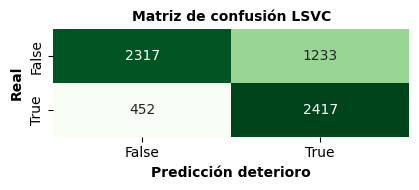

In [5]:
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = [False, True]
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción deterioro', fontweight='bold')
plt.ylabel('Real', fontweight='bold')
plt.title('Matriz de confusión LSVC', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# Ajuste de RECALL (Detección de positivos)

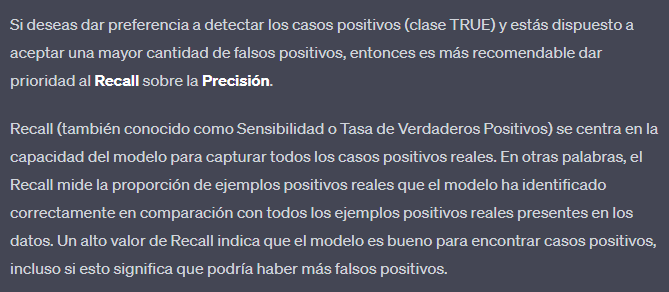

              precision    recall  f1-score   support

       False       0.86      0.53      0.66      3550
        True       0.61      0.90      0.72      2869

    accuracy                           0.69      6419
   macro avg       0.74      0.71      0.69      6419
weighted avg       0.75      0.69      0.69      6419



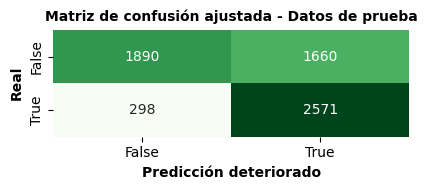

In [6]:
# Obtener las probabilidades estimadas
probabilities = modelo.predict_proba(x_test)[:, 1]  # Probabilidades de la clase positiva

# Definir umbral
threshold = 0.38

# Obtener las predicciones ajustadas después de ajustar el umbral de decisión
adjusted_predictions = (probabilities > threshold).astype(int)

# Generar el classification_report con las nuevas predicciones ajustadas
report = classification_report(y_test, adjusted_predictions)

# Generar la matriz de confusión con las nuevas predicciones ajustadas
conf_matrix = confusion_matrix(y_test, adjusted_predictions)

# Imprimir el classification_report y la matriz de confusión
print(report)
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción deteriorado', fontweight='bold')
plt.ylabel('Real', fontweight='bold')
plt.title('Matriz de confusión ajustada - Datos de prueba', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


In [7]:
# Guardar modelo entrenado

archivo_modelo = f'{DIRECTORIO_MODELOS}/LGR-nc.joblib'
joblib.dump(modelo, archivo_modelo)
print(f'Guardado modelo en {archivo_modelo}')

Guardado modelo en ../Modelos/LGR-nc.joblib


In [8]:
# Guardar columnas usadas

columnas_modelo = X.columns.to_list()
archivo_columnas = f'{DIRECTORIO_MODELOS}/COLUMNAS.txt'

with open(archivo_columnas, "w") as archivo:
    for col in columnas_modelo:
        archivo.write(col + '\n')

print(columnas_modelo)

['EDAD', 'DIAMETRO', 'LONGITUD', 'AREA', 'PROF_BATEA', 'PROF_BATE1', 'PENDIENTE', 'TIPO_AGUA_COMBINADAS', 'TIPO_AGUA_LLUVIAS Y DESCARGAS', 'TIPO_AGUA_OTRAS', 'MATERIAL_CONCRETO REFORZADO Y OTROS', 'MATERIAL_CONCRETO SIMPLE', 'MATERIAL_PVC', 'FABRICANTE_INDUSTRIAS DIQUE S.A.', 'FABRICANTE_MEXICHEM COLOMBIA S.A.S.', 'FABRICANTE_OTROS', 'ARRANQUE_NO', 'ARRANQUE_SI', 'ZONA_NORTE Y OTRAS', 'ZONA_SUR', 'MUNICIPIO_MEDELLÍN', 'MUNICIPIO_OTRO', 'ESTADO_OPERACION', 'ESTADO_OTRO']
